In [1]:
!pip install botorch
!pip install rdkit
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 481 kB 5.4 MB/s 
     |████████████████████████████████| 245 kB 45.8 MB/s 
     |████████████████████████████████| 152 kB 69.3 MB/s 
     |████████████████████████████████| 727 kB 63.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 270 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 5.3 MB/s 


In [2]:
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import rdmolfiles, rdmolops, AllChem, Draw, rdDepictor, Descriptors
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Fingerprints import FingerprintMols

from IPython.display import SVG
from IPython.display import HTML
from IPython.display import display

import torch
from botorch.models import SingleTaskGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from botorch.models.multitask import MultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.optim import Adam
from collections import defaultdict
from tqdm import tqdm

#**Load Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
fga = pd.read_csv("./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Data/Polymer_Solution_Cloud_Point_FGA.csv")

In [5]:
fga.tail()

,Unnamed: 0,Ring_p,HeteroRing_p,Carbocycles_p,nAromaticRing_p,nOHnNH_p,nNO_p,NumAtoms_p,fr_bicyclic_p,fr_tetrazole_p,...,ct_soneutral_s,ct_phosnegative_s,ct_fluorbenzene_s,Mw(Da),PDI,Φ,w,P(Mpa),CP,1-Phase
4828,4828,0,0,0,0,0,2,7,0,0,...,0,0,0,50000,1.5,0.44220,0.5056,0.1,63.14,negative
4829,4829,0,0,0,0,0,2,7,0,0,...,0,0,0,50000,1.5,0.09225,0.1159,0.1,71.08,negative
4830,4830,0,0,0,0,0,2,7,0,0,...,0,0,0,50000,1.5,0.11156,0.1394,0.1,72.63,negative
4831,4831,0,0,0,0,0,2,7,0,0,...,0,0,0,50000,1.5,0.34850,0.4083,0.1,73.50,negative
4832,4832,0,0,0,0,0,2,7,0,0,...,0,0,0,50000,1.5,0.26001,0.3119,0.1,73.50,negative


In [6]:
fga = fga.drop("Unnamed: 0", axis=1)

In [7]:
#Move CP column to the end
fga_cp = fga["CP"]
f = fga.drop("CP",axis=1)
f["CP"] = fga_cp
f.head()

,Ring_p,HeteroRing_p,Carbocycles_p,nAromaticRing_p,nOHnNH_p,nNO_p,NumAtoms_p,fr_bicyclic_p,fr_tetrazole_p,fr_oxime_p,...,ct_soneutral_s,ct_phosnegative_s,ct_fluorbenzene_s,Mw(Da),PDI,Φ,w,P(Mpa),1-Phase,CP
0,1,0,0,1,0,0,10,0,0,0,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,positive,21.34
1,1,0,0,1,0,0,10,0,0,0,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,positive,21.18
2,1,0,0,1,0,0,10,0,0,0,...,0,0,0,78800,1.12,0.00632,0.00700,0.10,positive,73.99
3,1,0,0,1,0,0,10,0,0,0,...,0,0,0,22100,1.03,0.11401,0.15300,1.02,positive,27.42
4,1,0,0,1,0,0,10,0,0,0,...,0,0,0,13500,1.06,0.17990,0.17990,4.35,positive,6.08


In [8]:
#For 1-Phase, use LabelEncoder to transfer str to int.
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit_transform(f["1-Phase"])

f["1-Phase"] = LE.fit_transform(f["1-Phase"])
f

,Ring_p,HeteroRing_p,Carbocycles_p,nAromaticRing_p,nOHnNH_p,nNO_p,NumAtoms_p,fr_bicyclic_p,fr_tetrazole_p,fr_oxime_p,...,ct_soneutral_s,ct_phosnegative_s,ct_fluorbenzene_s,Mw(Da),PDI,Φ,w,P(Mpa),1-Phase,CP
0,1,0,0,1,0,0,10,0,0,0,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,1,21.34
1,1,0,0,1,0,0,10,0,0,0,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,1,21.18
2,1,0,0,1,0,0,10,0,0,0,...,0,0,0,78800,1.12,0.00632,0.00700,0.10,1,73.99
3,1,0,0,1,0,0,10,0,0,0,...,0,0,0,22100,1.03,0.11401,0.15300,1.02,1,27.42
4,1,0,0,1,0,0,10,0,0,0,...,0,0,0,13500,1.06,0.17990,0.17990,4.35,1,6.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,0,0,0,2,7,0,0,0,...,0,0,0,50000,1.50,0.44220,0.50560,0.10,0,63.14
4829,0,0,0,0,0,2,7,0,0,0,...,0,0,0,50000,1.50,0.09225,0.11590,0.10,0,71.08
4830,0,0,0,0,0,2,7,0,0,0,...,0,0,0,50000,1.50,0.11156,0.13940,0.10,0,72.63
4831,0,0,0,0,0,2,7,0,0,0,...,0,0,0,50000,1.50,0.34850,0.40830,0.10,0,73.50


In [9]:
f_phase0 = f[f["1-Phase"]==0]
f_phase0_d = f_phase0.drop("1-Phase", axis=1)
f_phase1 = f[f["1-Phase"]==1]
f_phase1_d = f_phase1.drop("1-Phase", axis=1)

# **Model Building**

In [10]:
from sklearn.model_selection import train_test_split

X_0 = f_phase0_d.iloc[:, :-1].values
y_0 = f_phase0_d.iloc[:, -1].values
X_1 = f_phase1_d.iloc[:, :-1].values
y_1 = f_phase1_d.iloc[:, -1].values

#Feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_0_std = sc.fit_transform(X_0)
X_1_std = sc.fit_transform(X_1)

#Seperating literature data to training and validation data
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0_std, y_0, test_size=0.2, random_state=5)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1_std, y_1, test_size=0.2, random_state=5)

In [11]:
# A list for the evaluation result
rmse_sum_0 = {}
rmse_sum_1 = {}
r2_sum_0 = {}
r2_sum_1 = {}

## Lasso

In [12]:
from sklearn.linear_model import Lasso

lasso_0 = Lasso(alpha=0.1)
lasso_1 = Lasso(alpha=0.1)

lasso_0.fit(X_train_0, y_train_0)
lasso_1.fit(X_train_1, y_train_1)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e+04, tolerance: 4.312e+02
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

In [13]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train_0 = r2_score(y_train_0, lasso_0.predict(X_train_0))
RMSE_train_0 = mean_squared_error(y_train_0, lasso_0.predict(X_train_0), squared=False)
R_square_test_0 = r2_score(y_test_0, lasso_0.predict(X_test_0))
RMSE_test_0 = mean_squared_error(y_test_0, lasso_0.predict(X_test_0), squared=False)

print(f'R_square(Train_0): {R_square_train_0}\nRMSE(Train_0): {RMSE_train_0}')
print(f'R_square(Test_0): {R_square_test_0}\nRMSE(Test_0): {RMSE_test_0}\n')

R_square_train_1 = r2_score(y_train_1, lasso_1.predict(X_train_1))
RMSE_train_1 = mean_squared_error(y_train_1, lasso_1.predict(X_train_1), squared=False)
R_square_test_1 = r2_score(y_test_1, lasso_1.predict(X_test_1))
RMSE_test_1 = mean_squared_error(y_test_1, lasso_1.predict(X_test_1), squared=False)

print(f'R_square(Train_1): {R_square_train_1}\nRMSE(Train_1): {RMSE_train_1}')
print(f'R_square(Test_1): {R_square_test_1}\nRMSE(Test_1): {RMSE_test_1}')

R_square(Train_0): 0.9435465470146956
RMSE(Train_0): 17.02858443580725
R_square(Test_0): 0.9437323739423112
RMSE(Test_0): 17.179640950213564

R_square(Train_1): 0.7217073132166105
RMSE(Train_1): 22.375591339669988
R_square(Test_1): 0.6810549081006904
RMSE(Test_1): 24.681588565857023


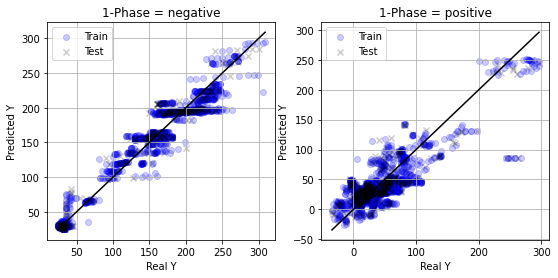

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_train_0, lasso_0.predict(X_train_0), alpha=0.2, c="blue", label='Train')
ax1.scatter(y_test_0, lasso_0.predict(X_test_0), alpha=0.2, c="black", marker='x', label='Test')
ax1.plot([y_train_0.min(), y_train_0.max()], [y_train_0.min(), y_train_0.max()], c="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Real Y")
ax1.set_ylabel("Predicted Y")
ax1.set_title("1-Phase = negative")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(y_train_1, lasso_1.predict(X_train_1), alpha=0.2, c="blue", label='Train')
ax2.scatter(y_test_1, lasso_1.predict(X_test_1), alpha=0.2, c="black", marker='x', label='Test')
ax2.plot([y_train_1.min(), y_train_1.max()], [y_train_1.min(), y_train_1.max()], c="black")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Real Y")
ax2.set_ylabel("Predicted Y")
ax2.set_title("1-Phase = positive")

fig.show()

In [15]:
rmse_sum_0['Linear Regression(Lasso)'] = [RMSE_train_0, RMSE_test_0] 
r2_sum_0['Linear Regression(Lasso)'] = [R_square_train_0, R_square_test_0] 
rmse_sum_1['Linear Regression(Lasso)'] = [RMSE_train_1, RMSE_test_1] 
r2_sum_1['Linear Regression(Lasso)'] = [R_square_train_1, R_square_test_1] 

## Ridge

In [16]:
from sklearn.linear_model import Ridge
ridge_0 = Ridge(alpha=0.1)
ridge_1 = Ridge(alpha=0.1)

ridge_0.fit(X_train_0, y_train_0)
ridge_1.fit(X_train_1, y_train_1)

Ridge(alpha=0.1)

In [17]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train_0 = r2_score(y_train_0, ridge_0.predict(X_train_0))
RMSE_train_0 = mean_squared_error(y_train_0, ridge_0.predict(X_train_0), squared=False)
R_square_test_0 = r2_score(y_test_0, ridge_0.predict(X_test_0))
RMSE_test_0 = mean_squared_error(y_test_0, ridge_0.predict(X_test_0), squared=False)

print(f'R_square(Train_0): {R_square_train_0}\nRMSE(Train_0): {RMSE_train_0}')
print(f'R_square(Test_0): {R_square_test_0}\nRMSE(Test_0): {RMSE_test_0}\n')

R_square_train_1 = r2_score(y_train_1, ridge_1.predict(X_train_1))
RMSE_train_1 = mean_squared_error(y_train_1, ridge_1.predict(X_train_1), squared=False)
R_square_test_1 = r2_score(y_test_1, ridge_1.predict(X_test_1))
RMSE_test_1 = mean_squared_error(y_test_1, ridge_1.predict(X_test_1), squared=False)

print(f'R_square(Train_1): {R_square_train_1}\nRMSE(Train_1): {RMSE_train_1}')
print(f'R_square(Test_1): {R_square_test_1}\nRMSE(Test_1): {RMSE_test_1}')

R_square(Train_0): 0.9458511800752164
RMSE(Train_0): 16.67737867582264
R_square(Test_0): 0.946934112562844
RMSE(Test_0): 16.683705012406346

R_square(Train_1): 0.7977973328411831
RMSE(Train_1): 19.072914621795412
R_square(Test_1): 0.7902073906266819
RMSE(Test_1): 20.01751852744178


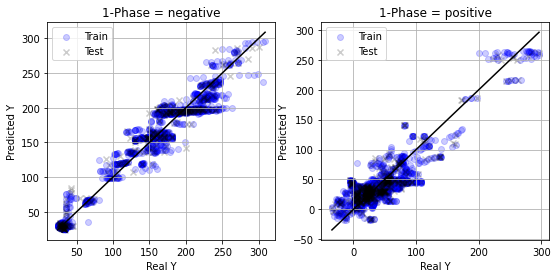

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_train_0, ridge_0.predict(X_train_0), alpha=0.2, c="blue", label='Train')
ax1.scatter(y_test_0, ridge_0.predict(X_test_0), alpha=0.2, c="black", marker='x', label='Test')
ax1.plot([y_train_0.min(), y_train_0.max()], [y_train_0.min(), y_train_0.max()], c="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Real Y")
ax1.set_ylabel("Predicted Y")
ax1.set_title("1-Phase = negative")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(y_train_1, ridge_1.predict(X_train_1), alpha=0.2, c="blue", label='Train')
ax2.scatter(y_test_1, ridge_1.predict(X_test_1), alpha=0.2, c="black", marker='x', label='Test')
ax2.plot([y_train_1.min(), y_train_1.max()], [y_train_1.min(), y_train_1.max()], c="black")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Real Y")
ax2.set_ylabel("Predicted Y")
ax2.set_title("1-Phase = positive")

fig.show()

In [19]:
rmse_sum_0['Linear Regression(Ridge)'] = [RMSE_train_0, RMSE_test_0] 
r2_sum_0['Linear Regression(Ridge)'] = [R_square_train_0, R_square_test_0] 
rmse_sum_1['Linear Regression(Ridge)'] = [RMSE_train_1, RMSE_test_1] 
r2_sum_1['Linear Regression(Ridge)'] = [R_square_train_1, R_square_test_1] 

## ElasticNet

In [20]:
from sklearn.linear_model import ElasticNet
EN_0 = ElasticNet(alpha=0.1)
EN_1 = ElasticNet(alpha=0.1)

EN_0.fit(X_train_0, y_train_0)
EN_1.fit(X_train_1, y_train_1)

ElasticNet(alpha=0.1)

In [21]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train_0 = r2_score(y_train_0, EN_0.predict(X_train_0))
RMSE_train_0 = mean_squared_error(y_train_0, EN_0.predict(X_train_0), squared=False)
R_square_test_0 = r2_score(y_test_0, EN_0.predict(X_test_0))
RMSE_test_0 = mean_squared_error(y_test_0, EN_0.predict(X_test_0), squared=False)

print(f'R_square(Train_0): {R_square_train_0}\nRMSE(Train_0): {RMSE_train_0}')
print(f'R_square(Test_0): {R_square_test_0}\nRMSE(Test_0): {RMSE_test_0}\n')

R_square_train_1 = r2_score(y_train_1, EN_1.predict(X_train_1))
RMSE_train_1 = mean_squared_error(y_train_1, EN_1.predict(X_train_1), squared=False)
R_square_test_1 = r2_score(y_test_1, EN_1.predict(X_test_1))
RMSE_test_1 = mean_squared_error(y_test_1, EN_1.predict(X_test_1), squared=False)

print(f'R_square(Train_1): {R_square_train_1}\nRMSE(Train_1): {RMSE_train_1}')
print(f'R_square(Test_1): {R_square_test_1}\nRMSE(Test_1): {RMSE_test_1}')

R_square(Train_0): 0.9383814191011113
RMSE(Train_0): 17.790540298290146
R_square(Test_0): 0.9405323004415265
RMSE(Test_0): 17.661409325933363

R_square(Train_1): 0.6590862769302688
RMSE(Train_1): 24.765429632586
R_square(Test_1): 0.5950303277812936
RMSE(Test_1): 27.811627059427682


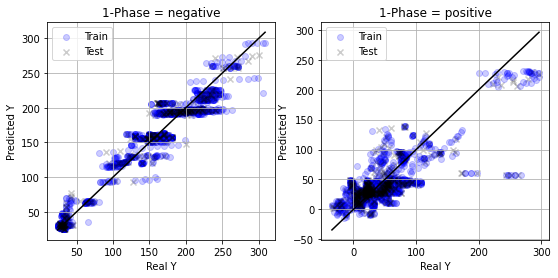

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_train_0, EN_0.predict(X_train_0), alpha=0.2, c="blue", label='Train')
ax1.scatter(y_test_0, EN_0.predict(X_test_0), alpha=0.2, c="black", marker='x', label='Test')
ax1.plot([y_train_0.min(), y_train_0.max()], [y_train_0.min(), y_train_0.max()], c="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Real Y")
ax1.set_ylabel("Predicted Y")
ax1.set_title("1-Phase = negative")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(y_train_1, EN_1.predict(X_train_1), alpha=0.2, c="blue", label='Train')
ax2.scatter(y_test_1, EN_1.predict(X_test_1), alpha=0.2, c="black", marker='x', label='Test')
ax2.plot([y_train_1.min(), y_train_1.max()], [y_train_1.min(), y_train_1.max()], c="black")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Real Y")
ax2.set_ylabel("Predicted Y")
ax2.set_title("1-Phase = positive")

fig.show()

In [23]:
rmse_sum_0['Linear Regression(ElasticNet)'] = [RMSE_train_0, RMSE_test_0] 
r2_sum_0['Linear Regression(ElasticNet)'] = [R_square_train_0, R_square_test_0] 
rmse_sum_1['Linear Regression(ElasticNet)'] = [RMSE_train_1, RMSE_test_1] 
r2_sum_1['Linear Regression(ElasticNet)'] = [R_square_train_1, R_square_test_1] 

## RF

In [24]:
from sklearn.ensemble import RandomForestRegressor
rf_0 = RandomForestRegressor()
rf_1 = RandomForestRegressor()

rf_0.fit(X_train_0, y_train_0)
rf_1.fit(X_train_1, y_train_1)

RandomForestRegressor()

In [25]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print("For 1-Phase = negative")
R_square_train_0 = r2_score(y_train_0, rf_0.predict(X_train_0))
RMSE_train_0 = mean_squared_error(y_train_0, rf_0.predict(X_train_0), squared=False)
R_square_test_0 = r2_score(y_test_0, rf_0.predict(X_test_0))
RMSE_test_0 = mean_squared_error(y_test_0, rf_0.predict(X_test_0), squared=False)

print(f'R_square(Train): {R_square_train_0}\nRMSE(Train): {RMSE_train_0}')
print(f'R_square(Test): {R_square_test_0}\nRMSE(Test): {RMSE_test_0}\n')

print("For 1-Phase = positive")
R_square_train_1 = r2_score(y_train_1, rf_1.predict(X_train_1))
RMSE_train_1 = mean_squared_error(y_train_1, rf_1.predict(X_train_1), squared=False)
R_square_test_1 = r2_score(y_test_1, rf_1.predict(X_test_1))
RMSE_test_1 = mean_squared_error(y_test_1, rf_1.predict(X_test_1), squared=False)

print(f'R_square(Train): {R_square_train_1}\nRMSE(Train): {RMSE_train_1}')
print(f'R_square(Test): {R_square_test_1}\nRMSE(Test): {RMSE_test_1}')

For 1-Phase = negative
R_square(Train): 0.9991791378153058
RMSE(Train): 2.0533756910550753
R_square(Test): 0.9951526448670542
RMSE(Test): 5.042398977186693

For 1-Phase = positive
R_square(Train): 0.9990609518903067
RMSE(Train): 1.2997731046726495
R_square(Test): 0.992109472276405
RMSE(Test): 3.8821129930158946


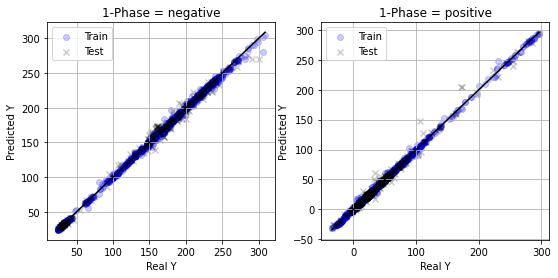

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_train_0, rf_0.predict(X_train_0), alpha=0.2, c="blue", label='Train')
ax1.scatter(y_test_0, rf_0.predict(X_test_0), alpha=0.2, c="black", marker='x', label='Test')
ax1.plot([y_train_0.min(), y_train_0.max()], [y_train_0.min(), y_train_0.max()], c="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Real Y")
ax1.set_ylabel("Predicted Y")
ax1.set_title("1-Phase = negative")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(y_train_1, rf_1.predict(X_train_1), alpha=0.2, c="blue", label='Train')
ax2.scatter(y_test_1, rf_1.predict(X_test_1), alpha=0.2, c="black", marker='x', label='Test')
ax2.plot([y_train_1.min(), y_train_1.max()], [y_train_1.min(), y_train_1.max()], c="black")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Real Y")
ax2.set_ylabel("Predicted Y")
ax2.set_title("1-Phase = positive")

fig.show()

In [27]:
rmse_sum_0['RF'] = [RMSE_train_0, RMSE_test_0] 
r2_sum_0['RF'] = [R_square_train_0, R_square_test_0] 
rmse_sum_1['RF'] = [RMSE_train_1, RMSE_test_1] 
r2_sum_1['RF'] = [R_square_train_1, R_square_test_1] 

## SVR

In [28]:
# from sklearn.svm import SVR
# svr = SVR()
# svr.fit(X_train, y_train)

In [29]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# R_square_train = r2_score(y_train, svr.predict(X_train))
# RMSE_train = mean_squared_error(y_train, svr.predict(X_train), squared=False)
# R_square_test = r2_score(y_test, svr.predict(X_test))
# RMSE_test = mean_squared_error(y_test, svr.predict(X_test), squared=False)

# print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
# print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

In [30]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,4))
# plt.scatter(y_train, svr.predict(X_train), alpha=0.2, c="blue", label='Train')
# plt.scatter(y_test, svr.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
# plt.legend()
# plt.grid()
# plt.xlabel("Real Y")
# plt.ylabel("Predicted Y")
# plt.show()

In [31]:
# rmse_sum['SVR'] = [RMSE_train, RMSE_test] 
# r2_sum['SVR'] = [R_square_train, R_square_test] 

## XGB

In [32]:
# import xgboost as xgb
# xgb_reg = xgb.XGBRegressor()
# params = {'metric':'rmse',
#           'objective':'reg:squarederror',
#           'n_estimators':5000,
#           'booster': 'gbtree',
#           'learning_rate':0.01,
#           'min_child_weight':1,
#           'max_depth':5,
#           'random_state':0,
#           'colsample_bytree':1,
#           'subsample':1,
#          }
# xgb_reg.set_params(**params)
# xgb_reg.fit(X_train, y_train)

In [33]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# R_square_train = r2_score(y_train, xgb_reg.predict(X_train))
# RMSE_train = mean_squared_error(y_train, xgb_reg.predict(X_train), squared=False)
# R_square_test = r2_score(y_test, xgb_reg.predict(X_test))
# RMSE_test = mean_squared_error(y_test, xgb_reg.predict(X_test), squared=False)

# print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
# print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

In [34]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,4))
# plt.scatter(y_train, xgb_reg.predict(X_train), alpha=0.2, c="blue", label='Train')
# plt.scatter(y_test, xgb_reg.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
# plt.legend()
# plt.grid()
# plt.xlabel("Real Y")
# plt.ylabel("Predicted Y")
# plt.show()

In [35]:
# rmse_sum['XGBoost'] = [RMSE_train, RMSE_test] 
# r2_sum['XGBoost'] = [R_square_train, R_square_test] 

## GpyTorch

In [36]:
from sklearn.model_selection import train_test_split

X_0 = f_phase0.iloc[:, :-1].values
y_0 = f_phase0.iloc[:, -1].values
X_1 = f_phase1.iloc[:, :-1].values
y_1 = f_phase1.iloc[:, -1].values

#Seperating literature data to training and validation data
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.2, random_state=5)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=5)

In [37]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# X must be in the range=(0, 1)
# use MinMaxScaler to transform features
mmscaler = MinMaxScaler()
X_train_mm_0 = mmscaler.fit_transform(X_train_0)
X_test_mm_0 = mmscaler.transform(X_test_0)
X_train_mm_1 = mmscaler.fit_transform(X_train_1)
X_test_mm_1 = mmscaler.transform(X_test_1)

X_train_tensor_0 = torch.from_numpy(np.array(X_train_mm_0))
X_test_tensor_0 = torch.from_numpy(np.array(X_test_mm_0))
X_train_tensor_1 = torch.from_numpy(np.array(X_train_mm_1))
X_test_tensor_1 = torch.from_numpy(np.array(X_test_mm_1))

# Y must be in the range=(-1, 1)
y_scaler = StandardScaler()

y_train_s_0 = y_scaler.fit_transform(y_train_0.reshape(-1, 1))
y_test_s_0 = y_scaler.transform(y_test_0.reshape(-1, 1))
y_train_s_1 = y_scaler.fit_transform(y_train_1.reshape(-1, 1))
y_test_s_1 = y_scaler.transform(y_test_1.reshape(-1, 1))

y_train_tensor_0 = torch.from_numpy(np.array(y_train_s_0))
y_test_tensor_0 = torch.from_numpy(np.array(y_test_s_0))
y_train_tensor_1 = torch.from_numpy(np.array(y_train_s_1))
y_test_tensor_1 = torch.from_numpy(np.array(y_test_s_1))

In [38]:
kernel_0 = RBFKernel(ard_num_dims=X_0.shape[1])

gp_0 = SingleTaskGP(X_train_tensor_0, y_train_tensor_0, covar_module=kernel_0)
mll_0 = ExactMarginalLogLikelihood(gp_0.likelihood, gp_0)

fit_gpytorch_model(mll_0)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
  )
)

In [39]:
kernel_1 = RBFKernel(ard_num_dims=X_1.shape[1])

gp_1 = SingleTaskGP(X_train_tensor_1, y_train_tensor_1, covar_module=kernel_1)
mll_1 = ExactMarginalLogLikelihood(gp_1.likelihood, gp_1)

fit_gpytorch_model(mll_1)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
  )
)

In [40]:
# import pickle

# with open('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Trained_model/gp_test.pkl', mode='wb') as f:
#   pickle.dump(gp,f)

In [41]:
# import pickle
# with open('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Trained_model/gp_test.pkl', mode='rb') as m:
#   gp = pickle.load(m)

In [42]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_train_pred_0 = gp_0.posterior(X_train_tensor_0).mean.detach().numpy().copy()
y_train_var_0 = gp_0.posterior(X_train_tensor_0).variance.detach().numpy().copy()
y_train_pred_1 = gp_1.posterior(X_train_tensor_1).mean.detach().numpy().copy()
y_train_var_1 = gp_1.posterior(X_train_tensor_1).variance.detach().numpy().copy()

y_test_pred_0 = gp_0.posterior(X_test_tensor_0).mean.detach().numpy().copy()
y_test_var_0 = gp_0.posterior(X_test_tensor_0).variance.detach().numpy().copy()
y_test_pred_1 = gp_1.posterior(X_test_tensor_1).mean.detach().numpy().copy()
y_test_var_1 = gp_1.posterior(X_test_tensor_1).variance.detach().numpy().copy()

print("For 1-Phase = negative")
R_square_train_0 = r2_score(y_train_s_0, y_train_pred_0)
RMSE_train_0 = mean_squared_error(y_scaler.inverse_transform(y_train_s_0), y_scaler.inverse_transform(y_train_pred_0), squared=False)
R_square_test_0 = r2_score(y_test_s_0, y_test_pred_0)
RMSE_test_0 = mean_squared_error(y_scaler.inverse_transform(y_test_s_0), y_scaler.inverse_transform(y_test_pred_0), squared=False)

print(f'R_square(Train): {R_square_train_0}\nRMSE(Train): {RMSE_train_0}')
print(f'R_square(Test): {R_square_test_0}\nRMSE(Test): {RMSE_test_0}\n')

print("For 1-Phase = positive")
R_square_train_1 = r2_score(y_train_s_1, y_train_pred_1)
RMSE_train_1 = mean_squared_error(y_scaler.inverse_transform(y_train_s_1), y_scaler.inverse_transform(y_train_pred_1), squared=False)
R_square_test_1 = r2_score(y_test_s_1, y_test_pred_1)
RMSE_test_1 = mean_squared_error(y_scaler.inverse_transform(y_test_s_1), y_scaler.inverse_transform(y_test_pred_1), squared=False)

print(f'R_square(Train): {R_square_train_1}\nRMSE(Train): {RMSE_train_1}')
print(f'R_square(Test): {R_square_test_1}\nRMSE(Test): {RMSE_test_1}\n')

/usr/local/lib/python3.8/dist-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.03303739813857318 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


For 1-Phase = negative
R_square(Train): 0.9907787272109383
RMSE(Train): 4.07304360584315
R_square(Test): 0.990418641178684
RMSE(Test): 4.1955477874364

For 1-Phase = positive
R_square(Train): 0.9936746143538755
RMSE(Train): 3.373394473669367
R_square(Test): 0.9842967970696785
RMSE(Test): 5.476577884614726



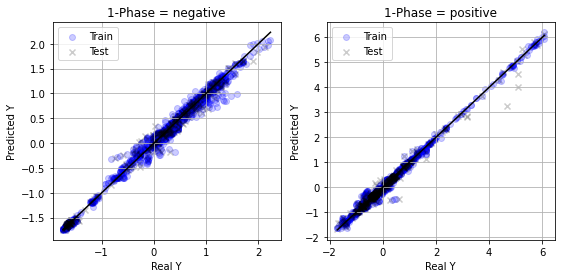

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_train_s_0, y_train_pred_0, alpha=0.2, c="blue", label='Train')
ax1.scatter(y_test_s_0, y_test_pred_0, alpha=0.2, c="black", marker='x', label='Test')
ax1.plot([y_train_s_0.min(), y_train_s_0.max()], [y_train_s_0.min(), y_train_s_0.max()], c="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Real Y")
ax1.set_ylabel("Predicted Y")
ax1.set_title("1-Phase = negative")

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(y_train_s_1, y_train_pred_1, alpha=0.2, c="blue", label='Train')
ax2.scatter(y_test_s_1, y_test_pred_1, alpha=0.2, c="black", marker='x', label='Test')
ax2.plot([y_train_s_1.min(), y_train_s_1.max()], [y_train_s_1.min(), y_train_s_1.max()], c="black")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Real Y")
ax2.set_ylabel("Predicted Y")
ax2.set_title("1-Phase = positive")

fig.show()

In [44]:
rmse_sum_0['GP'] = [RMSE_train_0, RMSE_test_0] 
r2_sum_0['GP'] = [R_square_train_0, R_square_test_0] 
rmse_sum_1['GP'] = [RMSE_train_1, RMSE_test_1] 
r2_sum_1['GP'] = [R_square_train_1, R_square_test_1] 

# **Summary**

In [45]:
summary = pd.concat([pd.DataFrame(r2_sum_0, index=['Train (R square)', 'Test (R square)']), pd.DataFrame(rmse_sum_0, index=['Train (RMSE)', 'Test (RMSE)'])])
summary.style.set_caption("1-Phase = negative")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,GP
Train (R square),0.943547,0.945851,0.938381,0.999179,0.990779
Test (R square),0.943732,0.946934,0.940532,0.995153,0.990419
Train (RMSE),17.028584,16.677379,17.790540,2.053376,4.073044
Test (RMSE),17.179641,16.683705,17.661409,5.042399,4.195548


In [46]:
summary = pd.concat([pd.DataFrame(r2_sum_1, index=['Train (R square)', 'Test (R square)']), pd.DataFrame(rmse_sum_1, index=['Train (RMSE)', 'Test (RMSE)'])])
summary.style.set_caption("1-Phase = positive")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,GP
Train (R square),0.721707,0.797797,0.659086,0.999061,0.993675
Test (R square),0.681055,0.790207,0.595030,0.992109,0.984297
Train (RMSE),22.375591,19.072915,24.765430,1.299773,3.373394
Test (RMSE),24.681589,20.017519,27.811627,3.882113,5.476578


# **Feature Importance**

1-Phase = negative

Text(0.5, 0, 'Feature Importance')

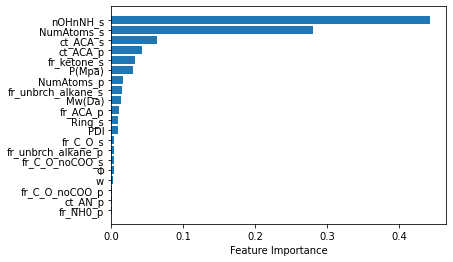

In [47]:
import matplotlib.pyplot as plt

sort = rf_0.feature_importances_.argsort()
plt.barh(f_phase0.columns[sort].astype(str)[-20:], rf_0.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

In [50]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model=rf_0, feature_perturbation='tree_path_dependent', model_output='margin')
shap_values = explainer.shap_values(X=f_phase0)
shap_values

array([[-4.03583422e-02,  0.00000000e+00,  0.00000000e+00, ...,
        -6.45447866e-01,  0.00000000e+00,  0.00000000e+00],
       [-1.76091415e-02,  0.00000000e+00,  0.00000000e+00, ...,
         3.27894753e+01,  0.00000000e+00,  0.00000000e+00],
       [-1.27834332e-02,  0.00000000e+00,  0.00000000e+00, ...,
         8.51286701e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.65304702e-01,  0.00000000e+00,  0.00000000e+00, ...,
        -2.89274008e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.64863537e-01,  0.00000000e+00,  0.00000000e+00, ...,
        -2.79271087e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.64897486e-01,  0.00000000e+00,  0.00000000e+00, ...,
        -2.77716090e+00,  0.00000000e+00,  0.00000000e+00]])

model_output = "margin" has been renamed to model_output = "raw"


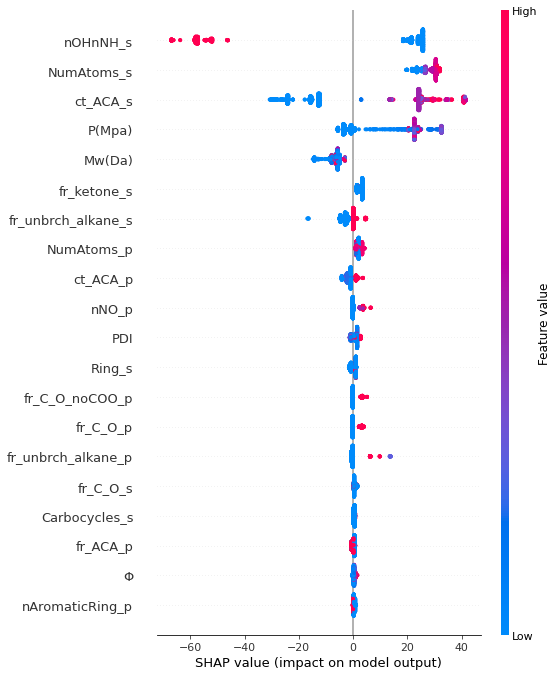

In [ ]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model=rf_0, feature_perturbation='tree_path_dependent', model_output='margin')
shap_values = explainer.shap_values(X=f_phase0)
shap.summary_plot(shap_values, f_phase0)

1-Phase = positive

Text(0.5, 0, 'Feature Importance')

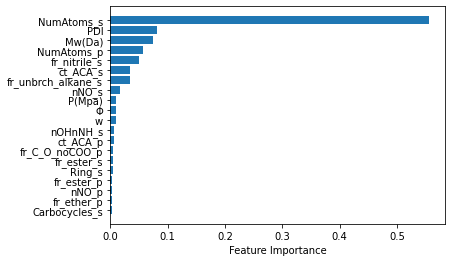

In [ ]:
import matplotlib.pyplot as plt

sort = rf_1.feature_importances_.argsort()
plt.barh(f_phase1.columns[sort].astype(str)[-20:], rf_1.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

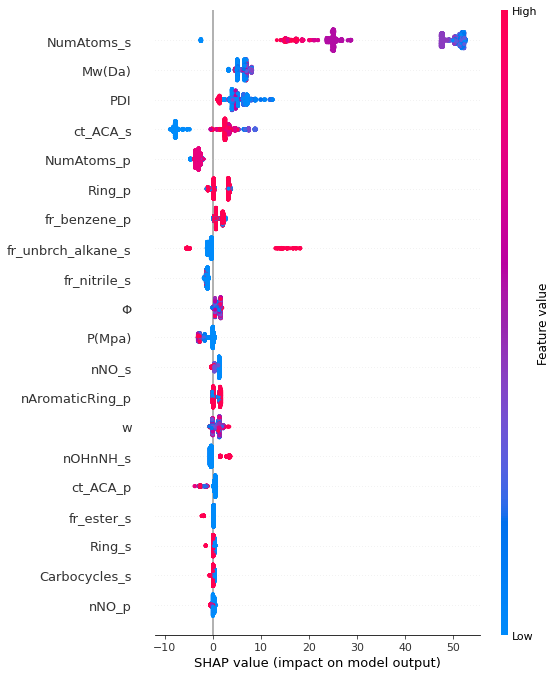

In [ ]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model=rf_1, feature_perturbation='tree_path_dependent', model_output='margin')
shap_values = explainer.shap_values(X=f_phase1)
shap.summary_plot(shap_values, f_phase1)

Shap of GP(未完成)

In [ ]:
class model_for_shap:
  
  def __init__(self, model):
    self.model = model
    return

  def predict(self, X):
    X_tensor = torch.from_numpy(np.array(X))
    return self.model.posterior(X_tensor).mean.detach().numpy().copy()

1-Phase = negative

In [ ]:
import shap

gp_shap = model_for_shap(gp_0)
explainer = shap.KernelExplainer(gp_shap.predict, X_train_0)
shap_values = explainer.shap_values(X_train_0)[0]


  0%|          | 0/1468 [00:00<?, ?it/s]

In [ ]:
shap.summary_plot(shap_values, X_train_0)